In [1]:
from collections import Counter
import logging
from operator import itemgetter
import pickle
from pprint import pprint
import time

import torch
import numpy as np
import pandas as pd
from pandas import option_context

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures

import gensim
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.matutils import Sparse2Corpus
from gensim.models import Phrases
import pyLDAvis
import pyLDAvis.gensim_models

from tmtoolkit.topicmod.evaluate import metric_coherence_gensim

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN
from umap import UMAP

from tqdm import tqdm
from tabulate import tabulate

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from IPython.display import Image
from IPython.core.display import HTML 

%matplotlib inline

/home/lynn/anaconda3/envs/msds/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/lynn/anaconda3/envs/msds/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/lynn/anaconda3/envs/msds/lib/python3.10/site-packages/umap/distances.py:

In [2]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /home/lynn/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/lynn/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Topic Modeling of Medical Text

In this project we try to identify the topics represented in a set of medical abstracts.  This is an unsupervised task known as [topic modeling](https://en.wikipedia.org/wiki/Topic_model).  The idea is to extract the 'hidden' topics present in these documents.  

We will use the data from the Kaggle task [Medical Text Classification](https://www.kaggle.com/datasets/chaitanyakck/medical-text). The original task was multi-classification which required labeling an abstract with one of 5 topics:
1. digestive system diseases
2. cardiovascular diseases
3. neoplasms
4. nervous system diseases or
5. general pathological conditions

We will try to use various methods to extract these topics.  This is a difficult task because 'general pathological conditions' is not really a category but a panoply of ones.  Furthermore, there is a lot of overlap between 'general pathological conditions' and other categorie.  Such observations perhaps explain some of the difficulty of the original classification problem.  And finally, it's clear some documents are about multiple topics, as they usually are.

The topical modeling methods we will cover include
- Latent Semantic Analysis (LSA)
- Non-negative Matrix Factorization (NMF)
- Latent Dirichlet Allocation (LDA)
- BERTopic

These methods, in turn, use other, more general unsupervised methods such as matrix factorization and clustering.

# Exploratory Data Analysis

Let's first read in the dataset and take a look at the features and identify some initial target 'topics'.  We will only look at the training set to simplify things.

The data file is presumed to be in the current working directory. If this is not the case, modify the cell below.

In [3]:
def load_data(fn):
    data = []
    with open(fn) as f:
        for l in f:
            label, doc = l.rstrip().split('\t')
            data.append((doc, int(label)))
    docs, labels = zip(*data)
    return pd.DataFrame({'text': docs, 'label': labels})

In [4]:
train_df = load_data('med_text_train.dat')

This is text-oriented data, in which the only feature is **text**, with a numeric target of **label** (suggested topic) which would be mandatory to consider if we were doing classification.  We will just end up using the label to evaluate various topic modeling methods.

In [5]:
with option_context('display.max_colwidth', 200):
    display(train_df.head())

,text,label
0,Catheterization laboratory events and hospital outcome with direct angioplasty for acute myocardial infarction To assess the safety of direct infarct angioplasty without antecedent thrombolytic th...,4
1,"Renal abscess in children. Three cases of renal abscesses in children are described to illustrate the variable presenting features. An additional 23 pediatric cases, reported over the past ten yea...",5
2,Hyperplastic polyps seen at sigmoidoscopy are markers for additional adenomas seen at colonoscopy. Asymptomatic individuals undergoing screening flexible sigmoidoscopy were prospectively studied. ...,2
3,Subclavian artery to innominate vein fistula after insertion of a hemodialysis catheter. Insertion of hemodialysis catheters for temporary use is now preferentially performed by percutaneous infra...,5
4,Effect of local inhibition of gamma-aminobutyric acid uptake in the dorsomedial hypothalamus on extracellular levels of gamma-aminobutyric acid and on stress-induced tachycardia: a study using mic...,4


How many unique labels do we have?

In [6]:
train_df.label.nunique()

5

The labels correspond to the following topics:

1. neoplasms
2. digestive system diseases
3. nervous system diseases
4. cardiovascular diseases
5. general pathological conditions

In [7]:
topics = ['neoplasms', 'digestive system diseases', 'nervous system diseases', 'cardiovascular diseases', 'general pathological conditions']
topic_by_label = {c: l+1 for l, c in enumerate(topics)}

How large is the dataset?  This appears to be a medium-sized text dataset with 14438 documents.

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14438 entries, 0 to 14437
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    14438 non-null  object
 1   label   14438 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 225.7+ KB


There appears to be no null documents or those with empty text.

In [9]:
(train_df.text.apply(lambda t: len(t.strip()) == 0)).sum()

0

There are, however, 3211 duplicate docs.

In [10]:
len(train_df[train_df['text'].duplicated()])

3211

It appears that the same doc can have different labels.  If the labels were the same, the value in the next cell would not be 0.

In [11]:
len(train_df[train_df[['text', 'label']].duplicated()])

0

How many of these duplicates involve the label 'general pathological conditions'? If we have a more specific label like 'neoplasm' then we should choose it.

In [12]:
dupes = train_df[train_df['text'].duplicated()]

In [13]:
def get_max_label(dup_text):
    return max(list(train_df[train_df.text == dup_text].label))

In [14]:
dupctr = Counter(list(dupes.text.apply(get_max_label)))

In [15]:
for l, c in dupctr.most_common():
    print(f"{topics[l-1]}: {c}")

general pathological conditions: 2683
cardiovascular diseases: 230
nervous system diseases: 164
digestive system diseases: 134


In [16]:
dupctr.most_common()[0][1]/len(dupes)

0.8355652444721271

For our purpose, we just want unique docs.  We want to remove duplicated docs so the words in those documents don't get overrepresented and skew the analysis.

It looks like ~84% of them have the additional label 'general pathological conditions' so let's sort the dataset by label so  when we remove duplicates by choosing only the first one, we will choose the record with the lower label value, eliminating 'general pathological conditions' for these docs.  I'm also making a judgement call here that the topic of cancer, for example, is more important than cardiovascular disease, but in the absence of discussing duplicates with the original dataset owner, this will have to do.

In [17]:
train_df = train_df.sort_values('label').drop_duplicates(['text'], keep='first')

Now we have 11227 documents.

In [18]:
len(train_df)

11227

What is the distribution of the 5 topics?

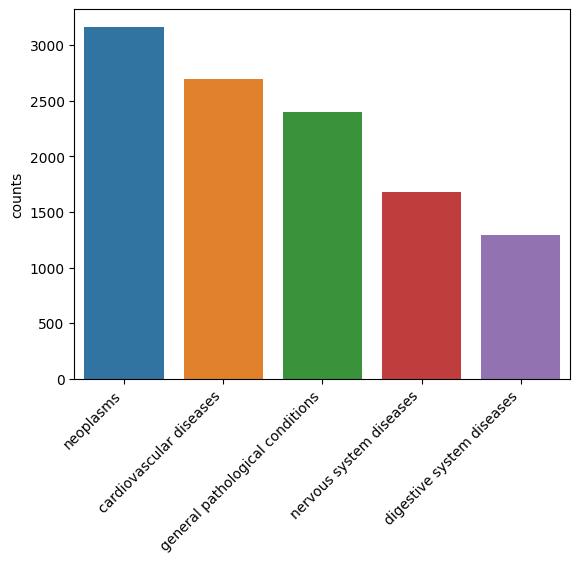

In [19]:
topic_idxs = train_df.label.value_counts().index.values
topic_counts = train_df.label.value_counts().values
topic_df = pd.DataFrame({'topic': np.array(topics)[topic_idxs-1], 'counts': topic_counts})
chart = sns.barplot(data=topic_df, x="topic", y="counts")
chart.set(xlabel=None)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right');

The largest category now appears to be neoplasms, perhaps unsurprising given the amount of research done on cancer.

Let's now look at the documents.  What are the document lengths?

The average doc length is 177 tokens


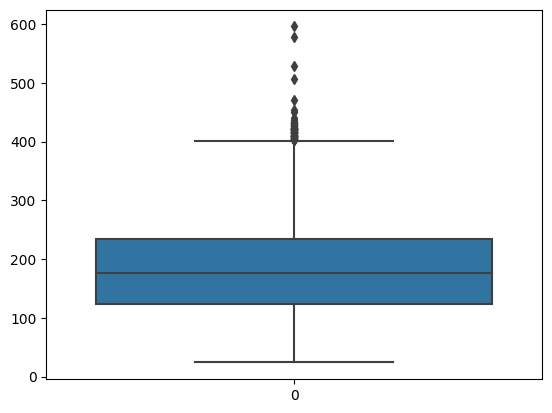

In [20]:
train_df['doc_len'] = train_df.text.apply(lambda x: len(x.split()))
sns.boxplot(train_df['doc_len']);
print(f"The average doc length is {int(np.median(train_df['doc_len']))} tokens")

We will remove documents greater than 400 tokens in length because 1) they probably contain multiple topics and 2) we use BERTopic below which in turn uses BERT [1].  The latter language model limits the doc length to about 500 tokens.

In [21]:
train_df = train_df.drop(train_df[train_df.doc_len > 400].index)

Now we are down to 11158 documents.

In [22]:
len(train_df)

11158

Do basic cleaning of text - remove punctuation and other non-alphanumeric characters to reduce noise and lower-case the text.

In [23]:
tokenizer = RegexpTokenizer(r'\w+')
def clean_text(text):
    """Split on whitespace and remove any tokens without any letters in them."""
    tokens = [t.lower() for t in tokenizer.tokenize(text) if not t.isnumeric()]
    return ' '.join(tokens)

In [24]:
train_df['clean_text'] = train_df.text.apply(clean_text)

What is the word distribution overall?  As shown below, the most frequent words are stop words.  For some of the methdos like LSA, LDA and NMF these should be removed.

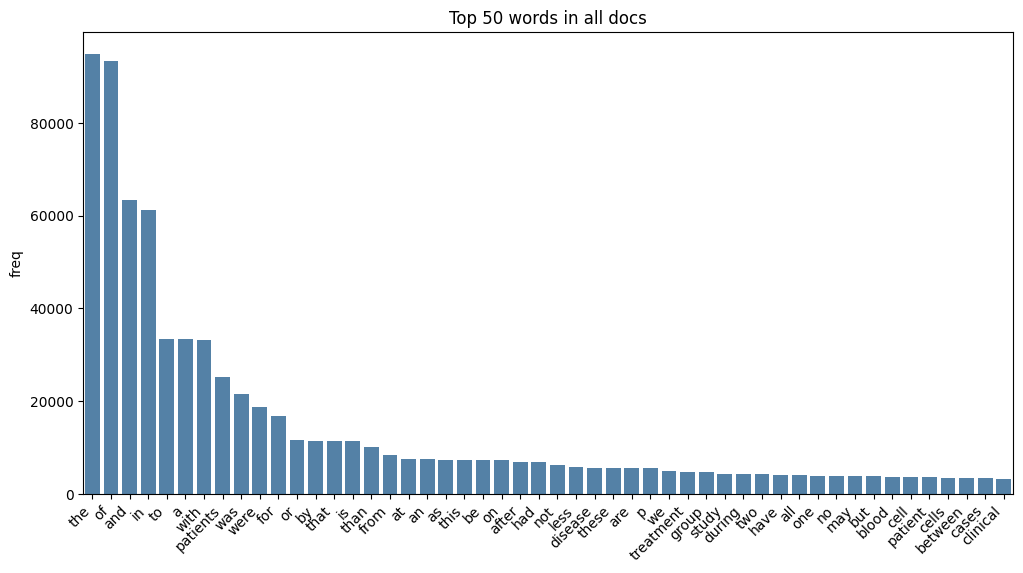

In [25]:
topk = 50
vocab_ctr = Counter([w for doc in train_df.clean_text for w in doc.split()])
words, freq = zip(*vocab_ctr.most_common()[:topk])

df = pd.DataFrame({'word': words, 'freq': freq})
plt.figure(figsize=(12, 6))
chart = sns.barplot(data=df, x='word', y='freq', color='steelblue')
chart.set_title(f"Top {topk} words in all docs")
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set(xlabel=None)
plt.show()

There are also a lot of stop words unique to the vocabularly in these documents.  We add these as well because they are effectively noise.

In [26]:
nltk.download('stopwords')
stop = set(stopwords.words("english"))
stop.update(['patient', 'patients', 'p', 'disease', 'may', 'treatment', 'less', 'group', 'study', 'clinical', 'one', 'two', 'three',
             'associated', 'years', 'results', 'case', 'cases', 'significantly', 'significant', 'showed', 'normal', 'age', 'rate', 'months', 'compared', 'treated',
             'normal', 'mean', 'also', 'group', 'found', 'groups', 'study', 'year', 'increased', 'time', 'greater', 'levels',
             'symptoms', 'therapy', 'risk', 'diagnosis', 'care', 'factors', 'hg', 'four', 'effects', 'n', 'used', 'using', 'studies', 'without',
             'type', 'five', 'b', 'mg', 'use', 'h', 'per', 'however', 'change', 'studied', 'analysis', 'finding', 'performed', 'report', 'present',
             'response', 'data', 'increase', 'effect', 'difference', 'well', 'day', 'observed', 'suggest', 'although', 'first', 'six', 'related',
             'similar', 'function', 'reported', 'complication', 'total', 'human', 'follow', 'higher', 'occurred', 'either', 'within', 'low',
             'developed', 'primary', 'induced', 'subjects', 'finding', 'findings', 'period', 'cell', 'cells'])

[nltk_data] Downloading package stopwords to /home/lynn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
vocab = vocab_ctr.keys()
vocab_wo_stop_words = set([v for v in vocab if v not in stop and len(v) > 1])

In [28]:
len(vocab_wo_stop_words)

35934

In [29]:
train_df['txt_wo_stops'] = train_df.clean_text.apply(lambda doc: ' '.join([w for w in doc.split() if w in vocab_wo_stop_words]))

We should remove words that occur less than a few times.

In [30]:
no_stop_vocab_ctr = Counter([w for doc in train_df.txt_wo_stops for w in doc.split()])

In [31]:
low_freq_words = set([w for w, c in no_stop_vocab_ctr.items() if c < 3])
print(len(low_freq_words))

15401


In [32]:
train_df['txt_wo_stops'] = train_df.txt_wo_stops.apply(lambda doc: ' '.join([w for w in doc.split() if w not in low_freq_words]))

In [33]:
print(f"vocabulary size = {len(no_stop_vocab_ctr)-len(low_freq_words)}")

vocabulary size = 20533


Let's look at the word distributions for each topic.  These all seem reasonable - cancer is associated with neoplasms, liver and gastric are associated with digestive system diseases, etc.

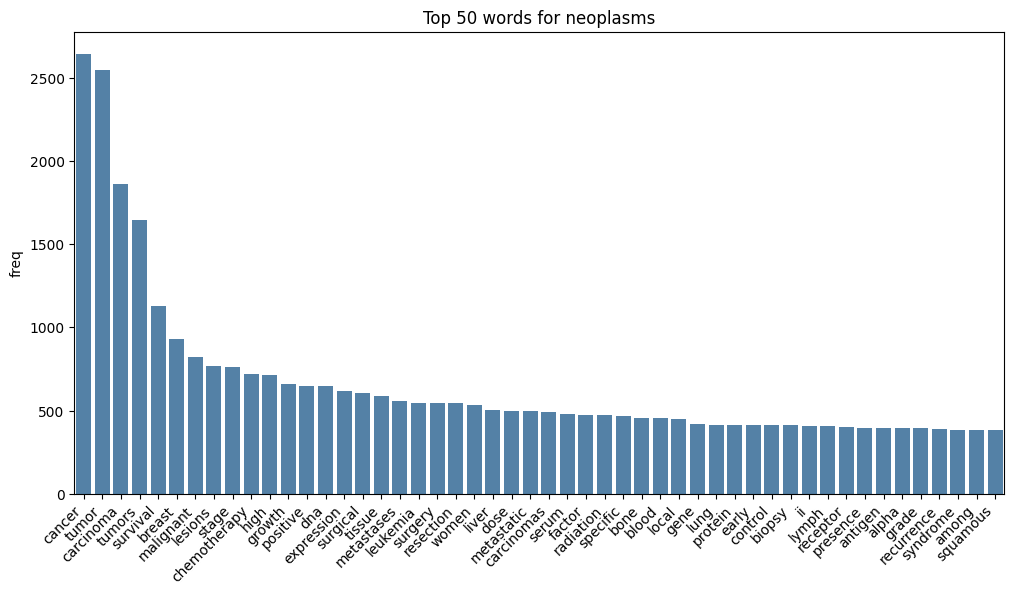

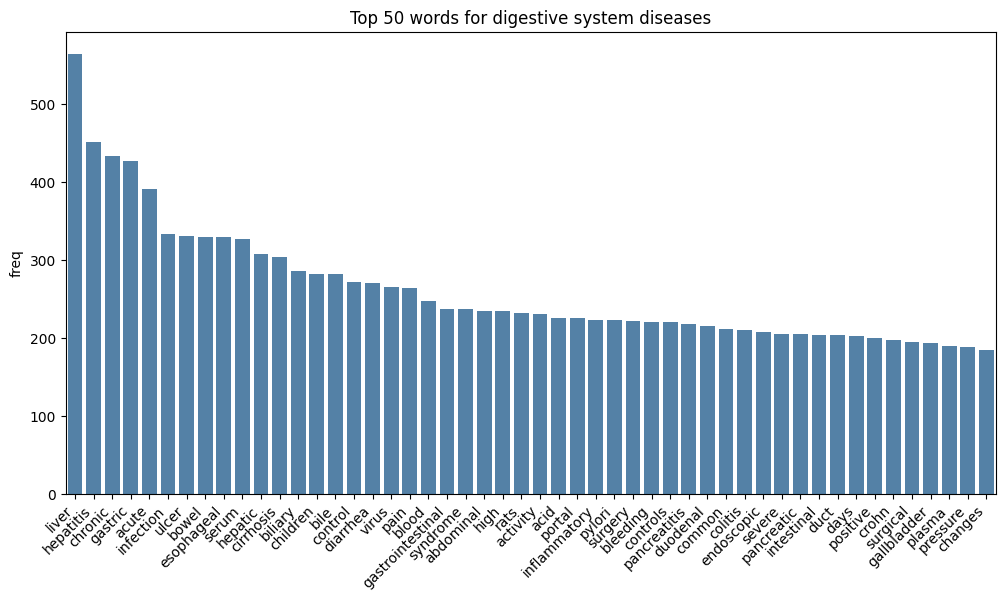

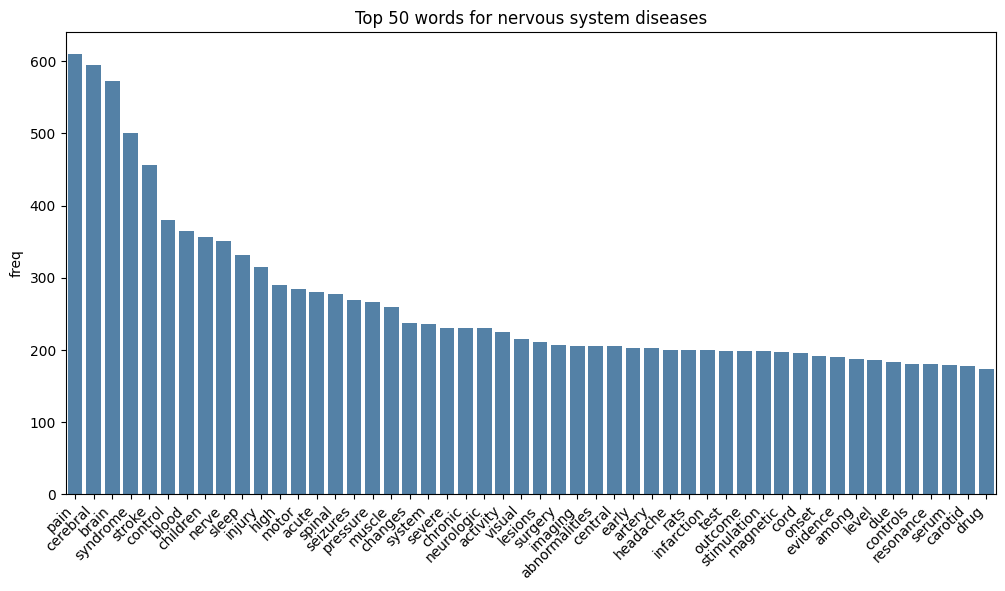

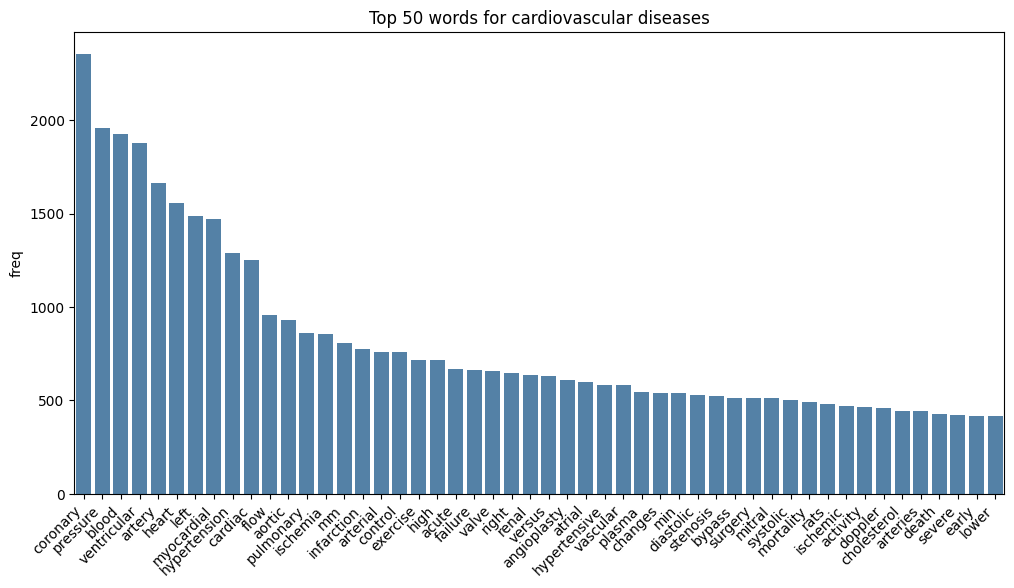

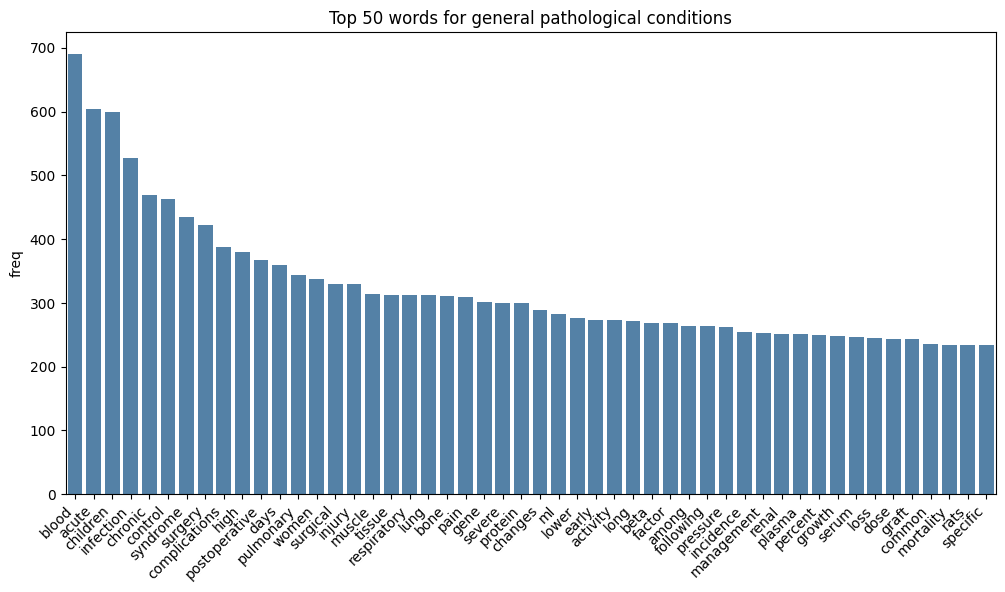

In [34]:
topk = 50
for category in train_df.label.unique():
    df_subset = train_df[train_df.label == category]
    cat_vocab_wo_stop_words_ctr = Counter([w for doc in df_subset.txt_wo_stops for w in doc.split()])
    cat_words_vocab_wo_stop_words, cat_freq_vocab_wo_stop_words = zip(*cat_vocab_wo_stop_words_ctr.most_common()[:topk])
    cat_wdist_wo_stop_words_chart_df = pd.DataFrame({'word': cat_words_vocab_wo_stop_words, 'freq': cat_freq_vocab_wo_stop_words})
    plt.figure(figsize=(12, 6))
    chart = sns.barplot(data=cat_wdist_wo_stop_words_chart_df, x='word', y='freq', color='steelblue')
    chart.set_title(f"Top {topk} words for {topics[category-1]}")
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
    chart.set(xlabel=None)
    plt.show()

Are the words in text correlated with each other?  Of course they are!  We can see this by viewing common bigrams, also known as collocations, or words that commonly co-occur. 

Specifically, we can use Pointwise Mutual Information (PMI) to measure this

$$
PMI(w_i, w_j) = log \frac{p(w_i, w_j)}{p(w_i)p(w_j)}
$$

We are measuring the probability of words appearing jointly together (numerator) vs appearing independently (denominator).

The NLTK library provides methods to calculate PMI for all terms in a corpus.  We just concatenate all of the abstracts to create our corpus.

Let's find the 10 bigrams with hightest PMI score.

In [35]:
bigram_measures = BigramAssocMeasures()
txt_wo_stops_corpus = [w for doc in train_df.txt_wo_stops for w in doc.split()]
bigram_collocation_finder = BigramCollocationFinder.from_words(txt_wo_stops_corpus)
bigram_collocation_finder.apply_freq_filter(3)

for bigram in bigram_collocation_finder.nbest(bigram_measures.pmi, 10):
    print(' '.join(bigram))

blom singer
carbonic anhydrase
cartilago stapediopexy
chlorhexidine rinsing
chondrodermatitis nodularis
dbb ohb
ethosuximide esm
facio scapulo
fresnel prisms
gamete intrafallopian


'blom singer' refers to a voice prosthesis. Others refer to procedures, molecules, etc.  At any rate, we won't see a feature like the term 'blom' without the term 'singer.'

sklearn's TfidfVectorizer has an option for finding ngrams where instead of PMI, it's just considering raw frequencies. Since that is what we will use below, let's do the same and just look at the top bigrams by frequency.

In [36]:
bigram_ctr = Counter([bigram for doc in train_df.txt_wo_stops for bigram in ngrams(doc.split(), 2)])

table = [['BIGRAM', 'FREQUENCY']]
for bigram, c in bigram_ctr.most_common()[:20]:
    table.append([' '.join(bigram), c])
print(tabulate(table))

---------------------  ---------
BIGRAM                 FREQUENCY
blood pressure         1210
coronary artery        943
left ventricular       907
long term              886
myocardial infarction  695
blood flow             614
magnetic resonance     527
breast cancer          506
heart failure          455
resonance imaging      372
computed tomography    334
growth factor          299
nervous system         281
bone marrow            280
ejection fraction      258
mitral valve           258
squamous carcinoma     256
double blind           255
pulmonary artery       252
spinal cord            250
---------------------  ---------


We could add bigrams (or even trigrams and other higher order n-grams) as features but of course the downside is that there will be more sparsity.  We do add bigrams below due their importance in medical text.

Finally, we can transform our text by lemmatizing it.  Lemmatizing involves just capturing morphological variants in text, so 'dog', 'dogs', 'doggy' would all be treated the same.  Often it helps to simplify text this way when using bag-of-words representations like TF-IDF.  We use lemmatizing over stemming to make the words of topics easier to read.

We will make this a separate column - it helps with the methods used in the next section.  Ideally, we would use a lemmatizer geared towards the biomedical domain such as [BioLemmatizer](https://biolemmatizer.sourceforge.net/).  But it's only available in Java, not python.  Porting it is clearly beyond the scope of this project.

In [37]:
lemmatizer = WordNetLemmatizer() 
train_df['txt_wo_stops_lem'] = train_df.txt_wo_stops.apply(lambda doc: ' '.join([lemmatizer.lemmatize(w) for w in doc.split()]))

Now we have multiple columns corresponding to different ways we treat the text as features - just cleaned, stop words removed, and lemmatized text.

# Topic Modeling and Analysis

In this section we explore various topic modeling methods to extract the 5 topics and potentially any subtopics.

- Latent Semantic Analysis (LSA)
- Non-negative Matrix Factorization (NMF)
- Latent Dirichlet Allocation (LDA)
- BertTopic

Before we do, let's convert our documents into a feature matrix where the rows are the documents and the columns are TF-IDF scores for unigrams and bigrams in our corpus. Let's try this with the lemmatized text with stop words removed.

In [38]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=10, norm='l1').fit(train_df['txt_wo_stops_lem'])
feature_matrix = tfidf_vectorizer.fit_transform(train_df['txt_wo_stops_lem'])

This will be a sparse matrix with over 99% of the values equal to 0.

In [39]:
feature_matrix.shape, 1-(feature_matrix != 0).sum()/np.prod(feature_matrix.shape)

((11158, 11126), 0.9946165703112875)

Get the names of the terms corresponding to each column.  We will need this for the methods below.

In [40]:
tfidf_vocab = tfidf_vectorizer.get_feature_names_out()
len(tfidf_vocab), tfidf_vocab[:10], tfidf_vocab[-10:]

(11126,
 array(['111in', '125i', '131i', '14c', '18f', '1990s', '1st', '2a', '2b',
        '2nd'], dtype=object),
 array(['yr', 'yr old', 'zealand', 'zealand white', 'zero', 'zidovudine',
        'zollinger', 'zollinger ellison', 'zone', 'zymosan'], dtype=object))

In [41]:
idf_by_word = dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_vectorizer.idf_))
words_sorted_by_idf = sorted(idf_by_word.items(), key=itemgetter(1))

Let's look at the lowest scoring terms.  These should be fairly common.  NOTE: This is how we constructed our stop list above, i.e. by iteratively removing some of these low IDF terms.

In [42]:
table = [['TERM', 'IDF']]
for term, idf in words_sorted_by_idf[:10]:
    table.append([term, f"{idf:.3f}"])
print(tabulate(table))

--------  -----
TERM      IDF
control   2.880
high      2.948
blood     2.973
tumor     3.044
acute     3.237
artery    3.297
pressure  3.297
surgery   3.302
lesion    3.351
surgical  3.369
--------  -----


There are a number of terms that share the higest score.  Ramdomly sample a few.

In [43]:
highest_idf_score = words_sorted_by_idf[-1][1]
np.random.seed(42)
high_idf_words = np.random.permutation([w for w, s in idf_by_word.items() if s == highest_idf_score])[:10]
table = [['TERM', 'IDF']]
for term in high_idf_words:
    table.append([term, f"{idf_by_word[term]:.3f}"])
print(tabulate(table))

--------------------  -----
TERM                  IDF
nontraumatic          7.922
immune mediated       7.922
rate lower            7.922
hypertriglyceridemia  7.922
direct evidence       7.922
myc gene              7.922
protein content       7.922
ef                    7.922
purification          7.922
italian               7.922
--------------------  -----


Also, how do we measure how well a topic model performs, and thus compare different ones?  Measurement with unsupervised methods is much harder than with supervised methods since we typically don't have ground truth labels.  When humans are making the judgemnt, the 'right' set of topics will depend on the annotators knowledge of the subject.  Even still there is often inter-annotator disagreement. Automated methods can be used but they sometimes don't correlate well with human judgements. Regardless, we will try and use the following methods for comparing models and with hyperparameter selection:

- eyballing: look at the top words and assign a topic based on that; requires knowing the subject and is tedious but is considered more reliable than automated judgements
- coherence: an automated method which determine how semantically similar the top words are using measures like PMI
- human judgement: using predefined labels; we have these with the given dataset

For coherence we use *Umass coherence*, which is a modification of PMI that accounts for the ordering among the top N words of a topic:

$$
C_{UMass} = \frac{2}{N(N-1)} \sum_{i=2}^N \sum_{j=1}^{i-1}log \frac{P(w_i,w_j)+\epsilon}{P(w_i)P(w_j)}
$$

The higher the score the better.  This is thought to correlate better with human judgement than other methods.

Besides coherence, we would like topics to be diverse.  One common but rather crude (IMO) to assess diversity is to count the number of unique words present in topics.  The problem, which we will see below, is that two words that are semantically similar (ex. cancer and carcinoma) are treated as distinctly as words that are not (ex. cancer and myocardial.) A better way would be to embed the words using a model like word2vec and then compare them, but that is beyond the scope of this project.

## Latent Semantic Analysis (LSA)

LSA is a direct application of using SVD to extract topics, i.e. it's a method based on matrix factoriztaion.  The columns of the original matrix correspond to documents, while the rows (in our case) will correspond to TF-IDF counts.  SVD will factorize this matrix into three.  The first associates words with topics - a *topic-word matrix* in topic modeling parlance.  The last associates documents with topics.  The middle represents the relative importantance of topics.  All of these topics are 'hidden' - you have to look at the words associated with them to infer what they are.

Image below courtesy of [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2021/06/part-16-step-by-step-guide-to-master-nlp-topic-modelling-using-lsa/)

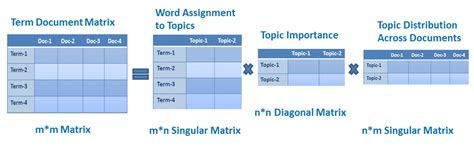

In [44]:
Image(filename = "img/lsa.jpg", width=1000, height=300)

In [45]:
def print_top_k_words(topic_word_matrix, k=10, vocab=tfidf_vocab):
    _, top_indices = torch.topk(torch.tensor(topic_word_matrix), k=k, axis=-1)
    for topic_k, top_words in enumerate(vocab[top_indices]):
        print(f"\nTopic {topic_k} is associated with these words: {', '.join(top_words)}")
    print()

def get_top_k_words_per_topic(topic_word_matrix, k=20, vocab=tfidf_vocab):
    _, top_indices = torch.topk(torch.tensor(topic_word_matrix), k=k, axis=-1)
    top_words = [', '.join(tw) for tw in vocab[top_indices]]
    return pd.DataFrame({"topic": list(range(1,len(top_words)+1)), f"top_{k}_words": top_words})

def get_diversity_score(topic_word_matrix, k=20, vocab=tfidf_vocab):
    _, top_indices = torch.topk(torch.tensor(topic_word_matrix), k=k, axis=-1)
    unique_words = set([w for top_words in vocab[top_indices] for w in top_words])
    return len(unique_words) / (k*topic_word_matrix.shape[0])

We start with 5 components corresponding to 5 topics.

In [46]:
lsa_model = TruncatedSVD(n_components=5, algorithm='randomized', random_state=42)
_ = lsa_model.fit_transform(feature_matrix)
lsa_topic_word_matrix = lsa_model.components_
df = get_top_k_words_per_topic(lsa_topic_word_matrix)
with option_context('display.max_colwidth', 200):
    display(df)

,topic,top_20_words
0,1,"tumor, cancer, carcinoma, blood, artery, syndrome, lesion, coronary, child, control, pressure, acute, surgery, infection, surgical, woman, survival, ventricular, left, pain"
1,2,"tumor, cancer, carcinoma, breast, metastasis, breast cancer, squamous, malignant, node, squamous carcinoma, dna, metastatic, stage, gene, survival, chemotherapy, adenocarcinoma, melanoma, expressi..."
2,3,"artery, coronary, tumor, carcinoma, aortic, coronary artery, valve, aneurysm, stenosis, lesion, angioplasty, surgical, graft, surgery, fistula, bypass, mitral, left, balloon, right"
3,4,"cancer, breast, coronary, tumor, breast cancer, pressure, carcinoma, blood, blood pressure, ventricular, artery, coronary artery, myocardial, heart, left, survival, node, flow, hypertension, left ..."
4,5,"cancer, breast, breast cancer, woman, child, pain, mortality, incidence, among, infection, death, complication, physician, survival, health, hospital, percent, screening, pregnancy, valve"


Most of the topics seem related to cancer, except topic 2 which is about cardiovascular disease. So they are coherent. But they don't really seem to be that distinct from each other.

In [47]:
coherence_model_lsa = metric_coherence_gensim('u_mass', topic_word_distrib=lsa_topic_word_matrix, dtm=feature_matrix, vocab=tfidf_vocab, return_coh_model=True)
lsa_coherence = coherence_model_lsa.get_coherence()
print(f"coherence = {lsa_coherence:.3f}, diversity={get_diversity_score(lsa_topic_word_matrix):.2f}")

coherence = -3.019, diversity=0.65


We can measure the coherence and diversity of the top 20 words over various number of topics to try to find the best settings for LSA.

In [48]:
n_components_list = [5, 8, 10, 13, 15, 18, 20, 30, 40, 50]
coherences = []
diversity_scores = []
for n_components in n_components_list:
    lsa_model = TruncatedSVD(n_components=n_components, algorithm='randomized', random_state=42)
    _ = lsa_model.fit_transform(feature_matrix)
    lsa_topic_word_matrix = lsa_model.components_
    coherence_model_lsa = metric_coherence_gensim('u_mass', topic_word_distrib=lsa_topic_word_matrix, dtm=feature_matrix, vocab=tfidf_vocab, return_coh_model=True)
    coherences.append(coherence_model_lsa.get_coherence())
    diversity_scores.append(get_diversity_score(lsa_topic_word_matrix))

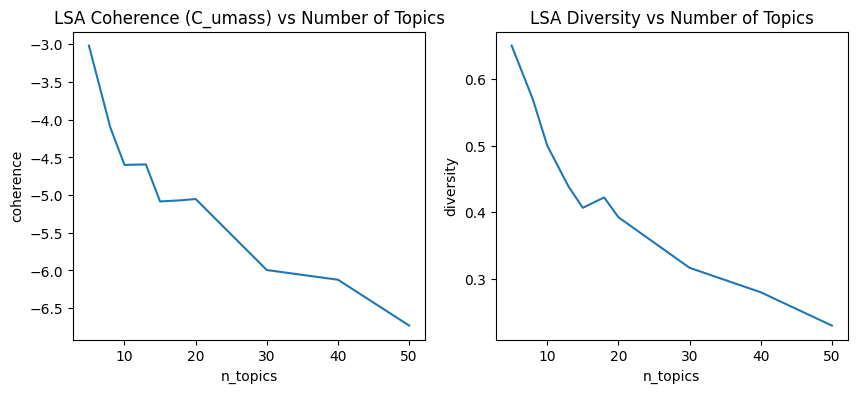

In [49]:
df = pd.DataFrame({'n_topics': n_components_list, 'coherence': coherences, 'diversity': diversity_scores})
fig, ax = plt.subplots(1, 2, figsize=(10,4))
chart = sns.lineplot(data=df, x='n_topics', y='coherence', ax=ax[0])
chart.set_title('LSA Coherence (C_umass) vs Number of Topics')
chart = sns.lineplot(data=df, x='n_topics', y='diversity', ax=ax[1])
chart.set_title('LSA Diversity vs Number of Topics');

The above diagrams would suggest that 5 topics are best for both coherence and diversity.  However, the diversity metric isn't the most accurate because all of the cancer-related terms are being treated differently even though they are semantically similar.

It's only when we bump up the number of topics to 20 that we see words related to nervous system diseases (ex. cerebral or spinal) and digestive system diseases (ex. biliary or duodenal).

In [50]:
lsa_model = TruncatedSVD(n_components=20, algorithm='randomized', random_state=42)
lsa_feature_matrix = lsa_model.fit_transform(feature_matrix)
lsa_topic_word_matrix = lsa_model.components_
df = get_top_k_words_per_topic(lsa_topic_word_matrix)
with option_context('display.max_colwidth', 200):
    display(df)

,topic,top_20_words
0,1,"tumor, cancer, carcinoma, blood, artery, syndrome, lesion, coronary, child, control, pressure, acute, surgery, infection, surgical, woman, survival, ventricular, left, pain"
1,2,"tumor, cancer, carcinoma, breast, metastasis, breast cancer, squamous, malignant, node, squamous carcinoma, dna, metastatic, stage, survival, chemotherapy, gene, adenocarcinoma, melanoma, expressi..."
2,3,"artery, coronary, tumor, carcinoma, aortic, coronary artery, aneurysm, lesion, valve, angioplasty, stenosis, graft, surgical, surgery, bypass, fistula, left, mitral, balloon, right"
3,4,"cancer, breast, coronary, tumor, breast cancer, pressure, carcinoma, blood, blood pressure, ventricular, artery, coronary artery, myocardial, heart, survival, left, node, flow, hypertension, metas..."
4,5,"cancer, breast, breast cancer, woman, pain, child, infection, mortality, incidence, among, complication, survival, surgery, death, physician, screening, percent, health, hospital, pregnancy"
5,6,"coronary, virus, infection, gene, artery, coronary artery, hepatitis, antibody, myocardial, hiv, protein, angioplasty, dna, acute, infarction, expression, receptor, hepatitis virus, leukemia, child"
6,7,"valve, mitral, aortic, ventricular, mitral valve, infection, virus, replacement, carcinoma, atrial, aortic valve, valve replacement, regurgitation, child, hepatitis, echocardiography, left, endoca..."
7,8,"ventricular, syndrome, imaging, magnetic, magnetic resonance, resonance, valve, breast, resonance imaging, cancer, mitral, left, breast cancer, atrial, mri, left ventricular, brain, cyst, aortic, ..."
8,9,"breast, aortic, cancer, aneurysm, artery, blood, breast cancer, valve, pressure, fistula, hypertension, vein, cyst, stenosis, graft, blood pressure, gene, lesion, mitral, renal"
9,10,"carcinoma, syndrome, child, infection, pressure, blood pressure, pulmonary, hypertension, blood, squamous, squamous carcinoma, hiv, lesion, coronary, lung, cyst, virus, old, artery, rare"


There's a lot of overlap in the topics.

For example, Topic 3 blurs neoplasms and cardiovascular disease with terms like "artery, coronary, tumor, carcinoma, aortic, coronary artery, aneurysm, etc." Ditto for Topic 4, 10, 13 and others.  Topic 15 covers neoplasms (ex. squamous, carcinoma) and digestive diseases (gastric, ulcer.)

It's really hard to eyeball and label these topics.  Let's give LSA the benefit of the doubt and try to assign the topics such that we optimize the accuracy of prediction using it.

In [51]:
def imperfect_oracle(n_topics, pred_fn):
    """
    Find the optimal category labeling of topics given a topic model.
    
    This is imperfect because we are assigning the optimal topics one position at a time - it's greedy.  We should perhaps do all combos
    but it's not worth the amount of time needed to optimize it.
    """
    best_topic_cats = [0] * n_topics
    best_combo = []
    best_acc = 0
    for i in range(n_topics):
        best_j = 0
        for j in range(5):
            best_topic_cats[i] = j
            topic_train_preds = pred_fn(best_topic_cats)
            acc = accuracy(train_df.label, topic_train_preds)
            if acc > best_acc:
                best_acc = acc 
                best_j = j
        best_topic_cats[i] = best_j

    print(f"Best accuracy was {best_acc:.3f}")
    return best_topic_cats

In [52]:
lsa_pred_fn = lambda cats: [cats[np.argmax(lsa_feature_matrix[i])]+1 for i in range(lsa_feature_matrix.shape[0])]

In [53]:
lsa_topic_cats = imperfect_oracle(20, lsa_pred_fn)

Best accuracy was 0.351


In [54]:
lsa_train_preds = [lsa_topic_cats[np.argmax(lsa_feature_matrix[i])]+1 for i in range(lsa_feature_matrix.shape[0])]

In [55]:
lsa_acc = accuracy(train_df.label, lsa_train_preds);lsa_acc

0.35051084423731854

This isn't particularly great.  Furthermore, when we re-run coherence, we see that it is has gone down.

In [56]:
coherence_model_lsa = metric_coherence_gensim('u_mass', topic_word_distrib=lsa_topic_word_matrix, dtm=feature_matrix, vocab=tfidf_vocab, return_coh_model=True)
lsa_coherence = coherence_model_lsa.get_coherence();lsa_coherence

-5.053764385368191

What does the model get wrong?  Based on the confusion matrix below, it seems that the model often predicts 'cardiovascular disease' when it shouldn't.  And this is mostly because the first topic is ambiguous - if we labeled it 'neoplasms' then the model would predict 'neoplasms' when it shouldn't.

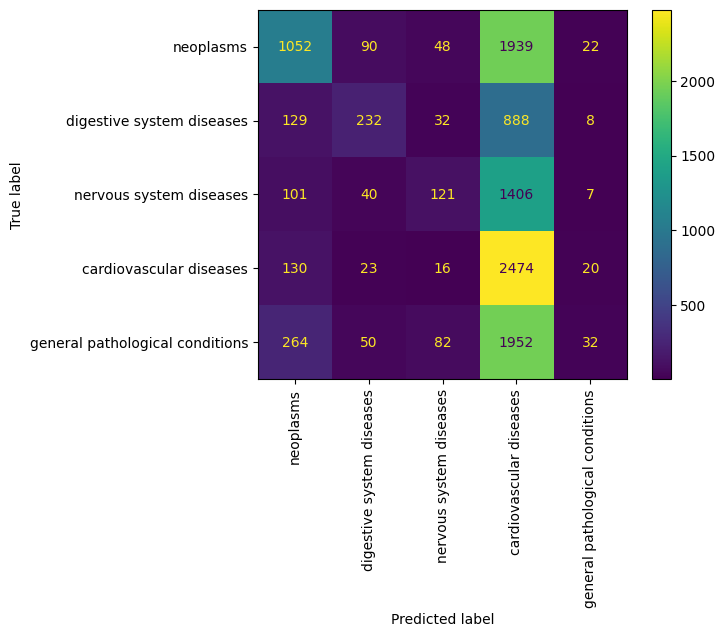

In [57]:
cm = confusion_matrix(train_df.label, lsa_train_preds, labels=list(range(1,6)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=topics)
disp.plot(xticks_rotation=90);

A big issue with SVD, like the diversity metric above, is that it ignores the semantics of words.  Also, it will produce negative values in the topic word matrix.  It's not clear what a negative value for a topic and a word mean.  Both of these issues end up impacting the results, particularly the interpretability.

And of course you have to figure out the number of topics - it's not an automatic process.  Also it requires a lot of preprocessing of the text as we have done to produce decent results.

On the positive side, it is fast.

## Non-negative Matrix Factorization (NMF)

NMF is another method based on matrix factorization. With NMF, a matrix can be factorized into two matrices. The first is a **mxk** *feature matrix* - **m** is the number of docs and **k** is the number of *topics*. It can be thought of as combining topics into documents.

The second is a **kxn** *component matrix* -  **k** is the number of *topics* and **n** is the vocabulary size. It can be thought of as associating words with topics. It's the topic-word matrix we associate with topic modeling.

Unlike, LSA (SVD), NMF will not produce negative values in the topic word matrix.

Create an NMF model using the same sparse doc/TF-IDF matrix we used for LSA and extract the feature and topic-word matrices.

In [58]:
def nmf_model(random_state, n_components=20):
    nmf = NMF(n_components=n_components, max_iter=1000, random_state=random_state)
    _ = nmf.fit(feature_matrix)
    nmf_feature_matrix = nmf.transform(feature_matrix)
    nmf_topic_word_matrix = nmf.components_
    return nmf_feature_matrix, nmf_topic_word_matrix

In [59]:
nmf_feature_matrix, nmf_topic_word_matrix = nmf_model(random_state=5, n_components=20)

In [60]:
df = get_top_k_words_per_topic(nmf_topic_word_matrix)
with option_context('display.max_colwidth', 200):
    display(df)

,topic,top_20_words
0,1,"surgery, complication, surgical, graft, fracture, procedure, technique, postoperative, injury, flap, cent, knee, operation, eye, bone, nerve, femoral, reconstruction, resection, limb"
1,2,"tumor, malignant, melanoma, metastasis, resection, chemotherapy, metastatic, benign, neoplasm, brain tumor, sarcoma, tissue, brain, survival, literature, multiple, lymphoma, radiation, carcinoid, ..."
2,3,"pressure, blood, blood pressure, hypertension, mm, hypertensive, systolic, diastolic, flow, blood flow, sodium, diastolic blood, doxazosin, heart, cholesterol, arterial, reduction, men, cardiovasc..."
3,4,"coronary, artery, coronary artery, angioplasty, myocardial, infarction, bypass, stenosis, coronary angioplasty, balloon, myocardial infarction, occlusion, angina, ptca, lesion, vessel, ischemia, g..."
4,5,"cancer, breast, breast cancer, woman, survival, lung cancer, stage, screening, estrogen, mammography, among, relative, lung, colorectal, colorectal cancer, chemotherapy, incidence, node, er, early"
5,6,"rat, concentration, plasma, control, serum, dose, activity, ml, kg, platelet, muscle, acid, infusion, drug, calcium, min, animal, microgram, protein, hour"
6,7,"valve, mitral, aortic, mitral valve, stenosis, replacement, aortic valve, valve replacement, regurgitation, balloon, valvuloplasty, endocarditis, echocardiography, doppler, aortic stenosis, valve ..."
7,8,"syndrome, disorder, eosinophilia, myalgia, muscle, tryptophan, eosinophilia myalgia, described, nevus, lesion, feature, myalgia syndrome, manifestation, cause, skin, abnormality, woman, family, ra..."
8,9,"ventricular, left, left ventricular, atrial, cardiac, heart, tachycardia, arrhythmia, fibrillation, ventricular tachycardia, myocardial, right, infarction, atrial fibrillation, myocardial infarcti..."
9,10,"infection, virus, hiv, hepatitis, immunodeficiency, hepatitis virus, antibody, immunodeficiency virus, infected, hiv infection, aid, hbv, virus infection, serum, positive, antigen, anti, chronic, ..."


The order of the following list is an assignment to the above extracted topics based on a visual inspection because I could understand the topics enough to do so.

In [61]:
categories = ['general pathological conditions',
              'neoplasms',
              'cardiovascular diseases',
              'cardiovascular diseases',
              'neoplasms',
              'general pathological conditions',
              'cardiovascular diseases',
              'nervous system diseases',
              'cardiovascular diseases',
              'general pathological conditions',
              'general pathological conditions',
              'nervous system diseases',
              'neoplasms',
              'digestive system diseases',
              'neoplasms',
              'general pathological conditions',
              'neoplasms',
              'cardiovascular diseases',
              'nervous system diseases',
              'digestive system diseases']

We can check how well these categories map to the original topics by using the NMF feature matrix to generate topic 'predictions' on the training set and then select the topic index with the highest score.

In [62]:
nmf_train_preds = [topic_by_label[categories[np.argmax(nmf_feature_matrix[i])]] for i in range(nmf_feature_matrix.shape[0])]

The accuracy isn't actually that bad, given that one of the top models on the supervised task had an accuracy of about 64%.

In [63]:
nmf_acc = accuracy(train_df.label, nmf_train_preds);nmf_acc

0.5457071159706041

What does the model get wrong?  Based on the confusion matrix below, it seems that the model often predicts 'general pathological conditions' when it shouldn't.

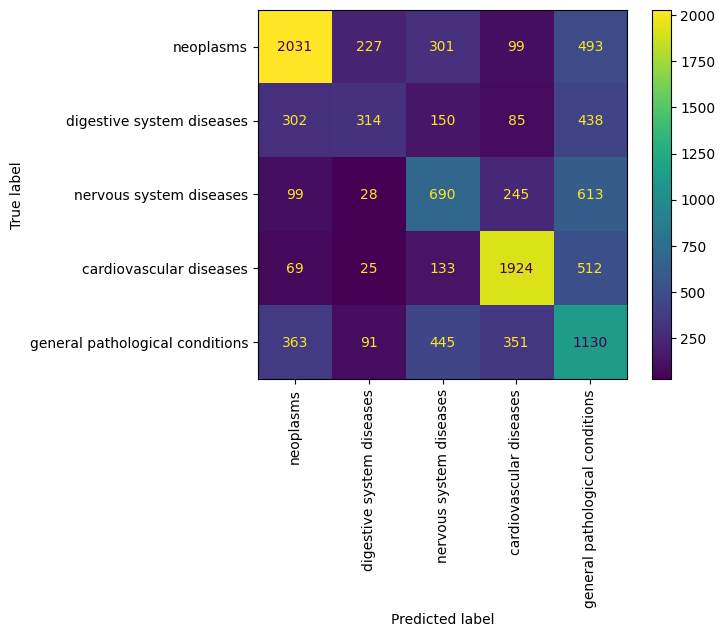

In [64]:
cm = confusion_matrix(train_df.label, nmf_train_preds, labels=list(range(1,6)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=topics)
disp.plot(xticks_rotation=90);

NMF is more coherent and diverse than the LSA model.

In [65]:
coherence_model_nmf = metric_coherence_gensim('u_mass', topic_word_distrib=nmf_topic_word_matrix, dtm=feature_matrix, vocab=tfidf_vocab, return_coh_model=True)
nmf_coherence = coherence_model_nmf.get_coherence()
print(f"coherence = {nmf_coherence:.3f}, diversity={get_diversity_score(nmf_topic_word_matrix):.2f}")

coherence = -3.508, diversity=0.86


Unfortunately, NMF has a serious problem.  If you repeat the above analysis with different random states, you will get different results! Let's try NMF with different random states.

In [66]:
for seed in [3, 5, 7, 11, 13, 29, 42, 51]:
    nmf_feature_matrix, nmf_topic_word_matrix = nmf_model(random_state=seed, n_components=20)
    nmf_train_preds = [topic_by_label[categories[np.argmax(nmf_feature_matrix[i])]] for i in range(nmf_feature_matrix.shape[0])]
    print(f"random state={seed}, accuracy = {accuracy(train_df.label, nmf_train_preds):.3f}")

random state=3, accuracy = 0.500
random state=5, accuracy = 0.546
random state=7, accuracy = 0.456
random state=11, accuracy = 0.454
random state=13, accuracy = 0.519
random state=29, accuracy = 0.457
random state=42, accuracy = 0.488
random state=51, accuracy = 0.505


Part of the problem is that the topics may need to be relabeled.  For example, topic 20 below was 'digestive system diseases', and now maybe it needs to be 'general pathological conditions'?

In [67]:
nmf_feature_matrix, nmf_topic_word_matrix = nmf_model(11, n_components=20)
df = get_top_k_words_per_topic(nmf_topic_word_matrix)
with option_context('display.max_colwidth', 200):
    display(df)

,topic,top_20_words
0,1,"graft, surgery, complication, surgical, fracture, procedure, technique, postoperative, flap, injury, cent, knee, nerve, operation, bone, eye, femoral, reconstruction, resection, limb"
1,2,"tumor, malignant, melanoma, chemotherapy, metastasis, resection, metastatic, benign, neoplasm, brain tumor, sarcoma, brain, survival, lymphoma, tissue, literature, dna, multiple, radiation, recurr..."
2,3,"pressure, blood, blood pressure, hypertension, hypertensive, mm, rat, plasma, flow, renal, systolic, sodium, diastolic, calcium, blood flow, control, arterial, heart, renin, diastolic blood"
3,4,"coronary, artery, coronary artery, angioplasty, myocardial, infarction, bypass, stenosis, coronary angioplasty, balloon, myocardial infarction, angina, occlusion, ptca, vessel, lesion, ischemia, c..."
4,5,"cancer, breast, breast cancer, woman, lung cancer, survival, stage, lung, estrogen, mammography, chemotherapy, colorectal, colorectal cancer, node, screening, relative, er, gastric cancer, ovarian..."
5,6,"gene, protein, receptor, alpha, beta, growth, expression, mutation, antibody, mouse, factor, il, activity, binding, rat, deletion, dna, leukemia, line, growth factor"
6,7,"valve, mitral, aortic, mitral valve, stenosis, replacement, aortic valve, valve replacement, regurgitation, balloon, valvuloplasty, endocarditis, echocardiography, doppler, valve area, aortic sten..."
7,8,"imaging, magnetic, resonance, magnetic resonance, resonance imaging, mri, lesion, ct, spinal, mr, tomography, computed, brain, computed tomography, image, cord, cerebral, scan, mr imaging, spinal ..."
8,9,"ventricular, left, left ventricular, atrial, cardiac, heart, tachycardia, fibrillation, arrhythmia, ventricular tachycardia, myocardial, right, infarction, atrial fibrillation, failure, heart fail..."
9,10,"infection, virus, hiv, hepatitis, immunodeficiency, hepatitis virus, immunodeficiency virus, infected, hiv infection, aid, antibody, hbv, virus infection, dna, positive, viral, htlv, chronic, anti..."


Regardless, the point is that NMF, like other optimization-based models, is sensitive to it's initial state which the variable 'random state' controls.

Also, like LSA, you have to preprocess the text for decent results and have to figure out the number of topics - it's not an automatic process.  But it's fast.

## Latent Dirichlet Allocation (LDA)

LDA is a probabilistic model in which topics have a distribution and each topic has its own word distribution.  Each document can be thought of as being generated by first picking one or more topics, and then selecting words based on each topic.  The topic distribution for a document is sampled from a Dirichlet distribution, hence the 'Dirichlet' part of the name.  'Latent' refers to the fact that what these topics are is not observed, only the document words.


Image below from [Topic Modeling in Python: Latent Dirichlet Allocation (LDA)](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0)

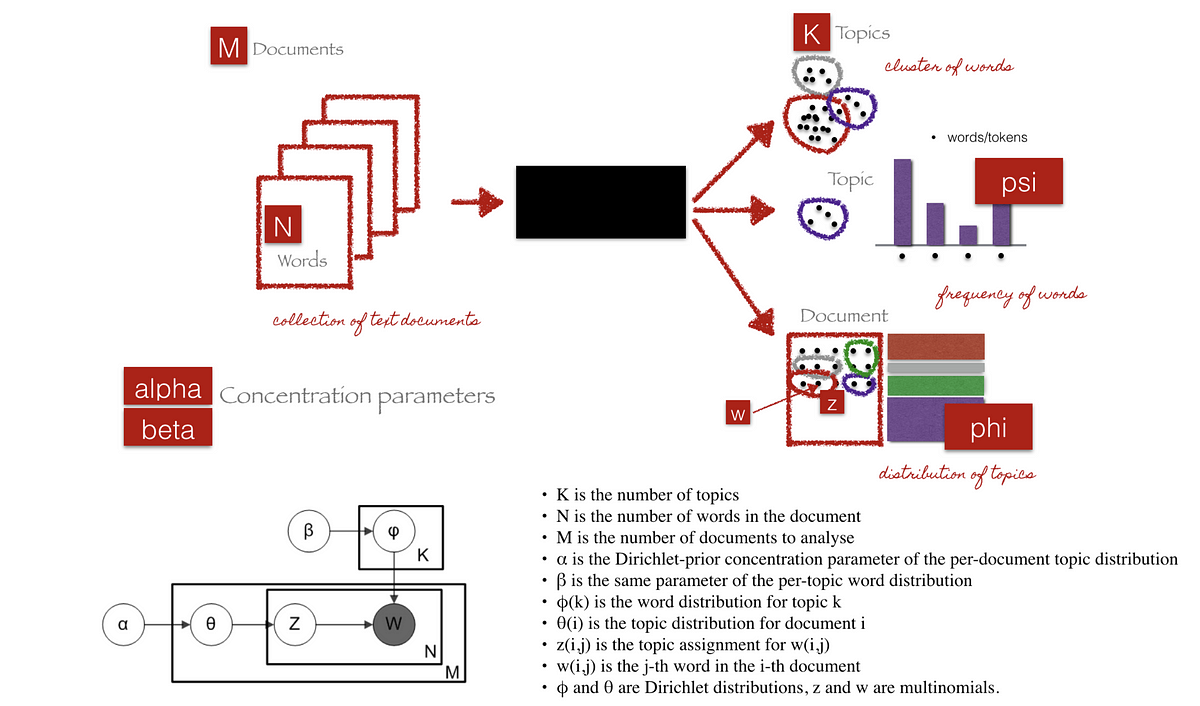

In [68]:
Image(filename = "img/lda.png", width=1000, height=300)

LDA has 2 critical hyperparameters - $\alpha$, which controls the prior belief on the document-topic distribution, and $\beta$, the prior belief on the topic-word distribution.

We are going to pivot to using the Gensim library for LDA because it has a pretty slick viz tool for analyzing an LDA model.

Note: We have to start with the cleaned, lemmatized text with stop words removed and re-introduce bigrams using gensim's processing. In theory, one could just convert any sklearn sparse matrix to a gensim 'corpus' using Sparse2Corpus.  Unfortunately, it doesn't handle bigrams too well - it expects bigrams to have underscores in them at a minimum.  It's just easier for now to to add the bigrams back in.

In [69]:
def reprocess_docs_for_lda(docs, min_bigram_count=10, min_df=10):
    # Add bigrams to docs (only ones that appear 10 times or more).
    # Code modified from gensim https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html
    bigram = Phrases(docs, min_count=min_bigram_count)
    for idx in range(len(docs)):
        for token in bigram[docs[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                docs[idx].append(token)
    
    dictionary = Dictionary(docs)
    # Filter out words that occur in less than 10 documents.
    dictionary.filter_extremes(no_below=min_df)

    corpus = [dictionary.doc2bow(doc) for doc in docs]

    return corpus, dictionary

In [70]:
lda_docs = [t.split(' ') for t in train_df['txt_wo_stops_lem']]
corpus, dictionary = reprocess_docs_for_lda(lda_docs)

In [71]:
print(f'Number of unique tokens: {len(dictionary)}')
print(f'Number of documents: {len(corpus)}')

Number of unique tokens: 9326
Number of documents: 11158


One big issue with LDA is that it takes a while to train, at least on this document set.  The proper way to train it is to log the perplexity and make sure it converges in a certain number of passes over the dataset.  We start by ensuring that it converges in 40 passes over the dataset for at least 20 topics.  The perplexity is an indirect measure of how the model is performing - the lower the perplexity the better.

This takes about 4 minutes to run.  There is a class in the Gensim library for parallelizing this - LdaMulticore.  Unfortunately, LdaMulticore does not support the autotuning of the hyperparameters $\alpha$ and $\beta$, and it doesn't speed up the training fast enough to justify having to go through the hyperparameter search manually.

Also note that since LDA is probabilistic, different runs will give different results.

We can also just load the pretrained model.

In [72]:
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [73]:
# tic = time.perf_counter()
# lda_model = LdaModel(corpus=corpus,
#                      id2word=dictionary,
#                      num_topics=20,
#                      random_state=42,
#                      chunksize=11158, # Use the whole set
#                      alpha='auto',
#                      eta='auto',
#                      passes=40,
#                      iterations=100,
#                      per_word_topics=True)
# toc = time.perf_counter()
# print(f"Training the LDA model took {toc - tic:0.4f} seconds")

In [74]:
# logging.disable(logging.CRITICAL)

Note: Gensim has a method for saving and loading models:

```
from gensim.test.utils import datapath

ldamodelfile = datapath("lda_topic_model")
lda_model.save(ldamodelfile)

lda_model = LdaModel.load("lda_topic_model")
```

Unfortunately, when I used this, and reran the coherence score, I don't get the same score.  So I just pickled the model as a workaround.

In [75]:
# with open("lda_topic_model.pkl", "wb") as fout:
#     pickle.dump(lda_model, fout)

In [76]:
with open("lda_topic_model.pkl", "rb") as f:
    lda_model = pickle.load(f, encoding='utf8')

In [77]:
coherencemodel = CoherenceModel(model=lda_model, texts=lda_docs, dictionary=dictionary, coherence='u_mass')
lda_coherence = coherencemodel.get_coherence(); lda_coherence

-3.436115002411961

Gensim uses pyLDAvis to visualize the topics and the top words associated with each.

In [78]:
pyLDAvis.enable_notebook()

In [79]:
visualization = pyLDAvis.gensim_models.prepare(lda_model,
                                               corpus,
                                               dictionary, 
                                               mds = "mmds", 
                                               R = 30)

In [80]:
visualization

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
16    -0.033902 -0.094860       1        1  8.045994
2     -0.294138  0.242578       2        1  7.749842
4      0.185806 -0.211069       3        1  6.438415
10    -0.288227 -0.224275       4        1  6.427479
9      0.071119 -0.010434       5        1  6.230208
6     -0.353880 -0.107943       6        1  6.172929
15     0.095379  0.217588       7        1  6.085904
11    -0.001905 -0.295520       8        1  5.615397
12    -0.152297 -0.299745       9        1  5.437341
5      0.321338 -0.155111      10        1  4.908950
14     0.079105 -0.302500      11        1  4.831024
8      0.088827  0.347179      12        1  4.639109
18    -0.277512 -0.011292      13        1  4.591853
13    -0.190003  0.005428      14        1  4.580445
0     -0.153675  0.194400      15        1  3.596841
1     -0.134841  0.347310      16        1  3.564591
7      0.150941  0.164333      17        1  3.346979
3      0.275829 -0.062623      18        1  2.864089
19     0.327196  0.038933      19        1  2.465841
17     0.284842  0.217624      20        1  2.406768, topic_info=             Term         Freq        Total Category  logprob  loglift
123         tumor  4452.000000  4452.000000  Default  30.0000  30.0000
1375       artery  2715.000000  2715.000000  Default  29.0000  29.0000
135        cancer  3026.000000  3026.000000  Default  28.0000  28.0000
331     carcinoma  2426.000000  2426.000000  Default  27.0000  27.0000
1422     coronary  2536.000000  2536.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
630      vascular   123.068791  1058.013041  Topic20  -5.2614   1.5755
1199    malignant   117.619262   943.312650  Topic20  -5.3067   1.6449
603         laser    97.976534   455.085787  Topic20  -5.4895   2.1911
345        severe   100.385400  1282.877723  Topic20  -5.4652   1.1790
2909  involvement    92.363491   444.055794  Topic20  -5.5485   2.1567

[1428 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
7803     10  0.973171                31p
4769     19  0.996788                99m
8694      8  0.991865   abdominal_aortic
1         1  0.054963        abnormality
1         2  0.012535        abnormality
...     ...       ...                ...
3432      5  0.024089              wound
3432      8  0.010324              wound
3432     12  0.017206              wound
5112     15  0.973059          zollinger
5113     15  0.973059  zollinger_ellison

[5579 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 3, 5, 11, 10, 7, 16, 12, 13, 6, 15, 9, 19, 14, 1, 2, 8, 4, 20, 18])

I had a hard time labeling these topics such that I would get a reasonable accuracy score on the training set. I think this highlights the challenge of trying to label topics based on eyeballing words.  It's a challenge to assign topics when the top words in the topic are not specific to just that topic.  I used the oracle again to select the topics for me and give the LDA the best chance on accuracy.

In [81]:
def get_lda_pred_for_ex(ex, cats):
    vec = lda_model[ex]
    return cats[sorted(vec[0], key=itemgetter(1), reverse=True)[0][0]]

In [82]:
lda_pred_fn = lambda cats: [get_lda_pred_for_ex(corpus[ex], cats)+1 for ex in range(len(corpus))]

This takes a very long time.  Like a half hour.  We just save that labeling for now by hardcoding it.

In [83]:
# The best labeling is 
# [1, 4, 0, 2, 4, 0, 3, 0, 3, 4, 3, 3, 3, 2, 0, 0, 3, 0, 3, 1]
# lda_topic_cats = imperfect_oracle(20, lda_pred_fn)

In [84]:
lda_topic_cats = [1, 4, 0, 2, 4, 0, 3, 0, 3, 4, 3, 3, 3, 2, 0, 0, 3, 0, 3, 1]

In [85]:
lda_train_preds = [get_lda_pred_for_ex(corpus[ex], lda_topic_cats)+1 for ex in range(len(corpus))]

In [86]:
lda_acc = accuracy(train_df.label, lda_train_preds);lda_acc

0.5377307761247535

The accuracy is close to NMF.

It looks we might be labeling general topics as more specific ones, again highlighting the issue of when words for topics overlap.

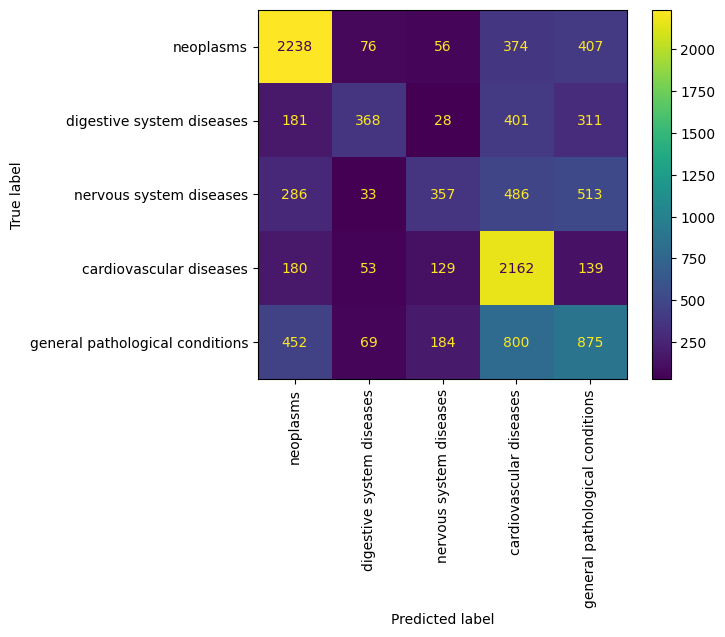

In [87]:
cm = confusion_matrix(train_df.label, lda_train_preds, labels=list(range(1,6)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=topics)
disp.plot(xticks_rotation=90);

So LDA may not be worse than NMF, but it's very slow.  It is nice the fine-tuning of 2 of the criticaly hyperameters (the topic-doc and topic-word priors) is a built-in option.

Like LSA and NMF, you have to preprocess the text for decent results and figure out the number of topics - it's not an automatic process.

Also, like LSA and NMF, it is treating our documents like a bag of words, clearly ignoring context in interpreting words.

Like NMF, it's not deterministic so training results may vary.

## BERTopic

All of the models above treat text as a bag of words.  But often the meaning of a word depends on its context.  For example, *cold* can mean two different things depending on whether one is talking about temperature or an illness.

Language models like BERT[1] capture the context around a word.  BERT is pre-trained on a corpus of over 3B words and is tasked with predicting randomly masked out words in that corpus. The base BERT model has ~110M parameters which presumably help capture general English linguistic information.

BERTopic[2] utilizes BERT to capture context.  It employs 4 steps:
1. Get the representation of a document using SentenceBERT[3] - a variant of BERT that presumably handles documents better than plain BERT
2. Reduce the dimensions of the resulting reprsentation using [UMAP](https://pair-code.github.io/understanding-umap/).  UMAP is a dimenionality reduction technique that keeps clusters tight but related ones closer to each other in space
3. Cluster the representations using HDBSCAN, a density-based clustering algorithm
4. Generate topic words for each cluster by using a variant of TF-IDF that relates the importance of a term to a cluster based on its frequency and its importance to the cluser:

$$
W_{t,c} = tf_{t,c} log(1+ \frac{A}{tf_t})
$$

$c$ refers to a cluster (a concatentation of all the docs in the cluster) and $t$ to a term.  $A$ is the average number of words per cluster.

One thing (in theory) about BERTopic is that we don't have to do any preprocessing of the text - it does lowercases and tokenizes text.  It will keep stop words.  This makes it considerably easier to use.

Also, we don't have to select the number of topics beforehand - it chooses the number of topics.

In [88]:
docs = list(train_df.text)

Let's train this model. For embedding text, we use their recommendation, SentenceTransformer.  With more time, we could use LMs's pretrained on biomedical text.

In [89]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

In [90]:
cluster_model = HDBSCAN(min_cluster_size = 15, 
                        metric = 'euclidean', 
                        cluster_selection_method = 'eom', 
                        prediction_data = True)

In [91]:
bert_topic_model = BERTopic(embedding_model=embedding_model, hdbscan_model=cluster_model)

Since BERT relies on Transformers[4], ideally this should be run on a GPU.

In [92]:
tic = time.perf_counter()

In [93]:
topics_per_doc, probs = bert_topic_model.fit_transform(docs)

In [94]:
toc = time.perf_counter()
print(f"Training the BERTopic took {toc - tic:0.4f} seconds")

Training the BERTopic took 31.0879 seconds


It generated over 140 topics! And this number will change each time we run this, i.e. there's a random component.

In [95]:
len(bert_topic_model.get_topics())

140

Looking at the largest clusters, they seem very specific.  The names given to a cluster are the top scoring words for the topic based on the formula above.

They are interpretable, at least compared to the above methods.  This may not be fair given those topic 'clusters' were much larger.  But it's nice that an attempt is made to label the clusters for you.  And seeing representive docs out of the box is extremely helpful.

In [96]:
with option_context('display.max_colwidth', 400):
    display(bert_topic_model.get_topic_info()[1:].head(5))

,Topic,Count,Name,Representation,Representative_Docs
1,0,332,0_bile_biliary_duct_pancreatic,"[bile, biliary, duct, pancreatic, pancreatitis, gallbladder, stones, cholecystectomy, gallstone, gallstones]",[Extracorporeal shock wave lithotripsy for biliary stones. Extracorporeal shock wave lithotripsy is a noninvasive technique for treatment of patients with gallbladder and bile duct stones. Selected patients with gallbladder stones can be treated on an outpatient basis without general anesthesia and may return to full activity within 1 or 2 days. Stone-free rates of 40% to 60% at 6 months have ...
2,1,319,1_pressure_hypertension_hypertensive_blood,"[pressure, hypertension, hypertensive, blood, rats, angiotensin, renin, sodium, salt, calcium]","[Role of angiotensin in the renal vasoconstriction observed during the development of genetic hypertension. Studies have examined renal function to determine the role of the kidney in the pathogenesis and maintenance phases of hypertension in the Okamoto-Aoki strain of spontaneously hypertensive rat (SHR). As compared to age-matched Wistar-Kyoto rats (WKY), 4- to 6-week old SHR are moderately ..."
3,2,217,2_gastric_ulcer_esophageal_reflux,"[gastric, ulcer, esophageal, reflux, duodenal, ph, peptic, omeprazole, ulcers, mucosal]","[Proximal gastric vagotomy in the emergency treatment of bleeding duodenal ulcer. Proximal gastric vagotomy for bleeding duodenal ulcer was performed in 52 low-risk patients between 1973 and 1986. Duodenotomy without violation of the pylorus was done in all patients to allow inspection and control of the bleeding site. The median duration of operation was 3 hours and 20 minutes, although 25% o..."
4,3,198,3_tachycardia_ventricular_atrial_vt,"[tachycardia, ventricular, atrial, vt, fibrillation, arrhythmias, conduction, av, sustained, pacing]","[Determinants of the ventricular rate during atrial fibrillation. Determinants of the ventricular cycle length during atrial fibrillation were examined in 52 patients. Thirty-three patients had structural heart disease and none had an accessory atrioventricular (AV) connection. The AV node effective and functional refractory periods, the shortest atrial pacing cycle length associated with 1:1 ..."
5,4,171,4_eyes_retinal_visual_intraocular,"[eyes, retinal, visual, intraocular, eye, acuity, optic, macular, cataract, retinopathy]","[Extracapsular cataract extraction with intraocular lens implantation after scleral buckling surgery. We reviewed the records of 28 patients who had undergone successful scleral buckling surgery followed by extracapsular cataract extraction with implantation of an intraocular lens. Posterior chamber intraocular lenses were inserted in 27 eyes, and anterior chamber intraocular lenses were inser..."


What is the coherence?

In [97]:
def get_coherence(topics_per_doc, bert_topic_model):
    """
    Code from https://github.com/MaartenGr/BERTopic/issues/90.  It should be in framework but isn't yet.
    """
    # Preprocess Documents
    documents = pd.DataFrame({"Document": docs,
                              "ID": range(len(docs)),
                              "Topic": topics_per_doc})
    documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
    cleaned_docs = bert_topic_model._preprocess_text(documents_per_topic.Document.values)

    # Extract vectorizer and analyzer from BERTopic
    vectorizer = bert_topic_model.vectorizer_model
    analyzer = vectorizer.build_analyzer()

    # Extract features for Topic Coherence evaluation
    words = vectorizer.get_feature_names_out()
    tokens = [analyzer(doc) for doc in cleaned_docs]
    dictionary = gensim.corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    topic_words = [[words for words, _ in bert_topic_model.get_topic(topic)] 
                   for topic in range(len(set(topics_per_doc))-1)]

    # Evaluate
    coherence_model = CoherenceModel(topics=topic_words, 
                                     texts=tokens, 
                                     corpus=corpus,
                                     dictionary=dictionary, 
                                     coherence='u_mass')
    return coherence_model.get_coherence()

In [98]:
get_coherence(topics_per_doc, bert_topic_model)

-1.0127420649728192

The coherence is -1, which is pretty high.  But that is expected given the number of topics.  Having over 140 topics is quite a lot, though.  Can we reduce this?  Yes, by setting nr_topics in the constructor.  Let's try 20.

To get rid of the randomness of this model, we have to hardcode UMAP.  Ideally, we wouldn't as the randomness is a key to better performance with UMAP. But we want replicatable results here.

In [99]:
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

In [100]:
bert_topic_20_topics_model = BERTopic(umap_model=umap_model, embedding_model=embedding_model, hdbscan_model=cluster_model, nr_topics=20)

In [101]:
topics_per_doc_bert_topic_20, _ = bert_topic_20_topics_model.fit_transform(docs)

In [102]:
len(bert_topic_20_topics_model.get_topics())

20

According to the [BERTopic FAQ](https://maartengr.github.io/BERTopic/faq.html#should-i-preprocess-the-data), one should not need to preprocess docs.  But we can perhaps see here that the representations and names have a lot of noise introduced by the presence of stop words.

In [103]:
with option_context('display.max_colwidth', 400):
    display(bert_topic_20_topics_model.get_topic_info())

,Topic,Count,Name,Representation,Representative_Docs
0,-1,4357,-1_the_of_and_in,"[the, of, and, in, to, with, patients, was, were, for]",[Pancreatic function in Crohn's disease. We investigated exocrine pancreatic function in a population of patients with Crohn's disease in order to correlate the pancreatic function with clinical and laboratory variables. A total of 143 patients affected by Crohn's disease and 115 control subjects were studied. All had a Lundh meal test. As a group patients with Crohn's disease had significantl...
1,0,1379,0_the_of_in_and,"[the, of, in, and, patients, to, was, with, were, than]","[Angiographic progression to total coronary occlusion in hyperlipidemic patients after acute myocardial infarction. POSCH Group. The progression of coronary artery stenosis to total occlusion was assessed in 413 hyperlipidemic patients with a previous myocardial infarction. Coronary angiograms were recorded at baseline, 3 (n = 312), and 5 years (n = 248) after initial study and analyzed by 2 i..."
2,1,1178,1_of_the_and_in,"[of, the, and, in, patients, with, cancer, to, for, was]","[Follicular thyroid cancer treated at the Mayo Clinic, 1946 through 1970: initial manifestations, pathologic findings, therapy, and outcome We retrospectively analyzed the outcome of all patients who received their primary treatment for follicular thyroid cancer at the Mayo Clinic between 1946 and 1970. The diagnosis was confirmed by reexamination of preserved tissue specimens. The 57 female a..."
3,2,859,2_the_of_in_and,"[the, of, in, and, with, patients, to, was, were, for]","[Primary carcinoma of the gallbladder. Seventy-four patients with primary carcinoma of the gallbladder, diagnosed over 18 years from 1969 to 1987, were studied retrospectively. The most common presenting complaint was abdominal pain, followed by jaundice and weight loss. Surgery was performed in 61 patients and of these patients, only two had accurate preoperative diagnosis which was made by u..."
4,3,565,3_in_the_and_of,"[in, the, and, of, pressure, to, blood, hypertension, with, cholesterol]","[Doxazosin: a study in a cohort of patients with hypertension in general practice--an interim report. The objective of this study was to assess the safety and efficacy of doxazosin in a substantial cohort of hypertensive patients drawn from general practice. A total of 4027 patients entered the study, 1472 of whom (36.6%) were untreated hypertensive patients. Patients were not advised to chang..."
5,4,394,4_virus_hepatitis_of_in,"[virus, hepatitis, of, in, and, the, with, infection, hiv, patients]","[Orthotopic liver transplantation for patients with hepatitis B virus-related liver disease Fifty-nine patients with prior hepatitis B virus infection underwent orthotopic liver transplantation. During the first 2 mo, mortality was not significantly different in the hepatitis B virus-infected group (25.5%) vs. a hepatitis B virus-immune control group (21%). Beyond 2 mo, the mortality, rate of ..."
6,5,355,5_cells_of_the_in,"[cells, of, the, in, and, cell, with, to, leukemia, tumor]","[Philadelphia chromosome and monosomy 7 in childhood acute lymphoblastic leukemia: a Pediatric Oncology Group study. During an 8-year period, 3,638 children from institutions of the Pediatric Oncology Group (POG) were diagnosed with acute lymphoblastic leukemia (ALL). Fifty-seven patients had Philadelphia chromosome-positive (Ph1) ALL. Blast cells obtained at diagnosis from 13 of these 57 case..."
7,6,303,6_the_of_and_in,"[the, of, and, in, were, patients, to, was, with, nerve]","[Factors influencing the results of open reduction and internal fixation of tibial plateau fractures. Forty-three displaced tibial plateau fractures were treated with open reduction and internal fixation. The fractures were classified into four groups, and the clinical results were evaluated using a standard 100-point knee rating system. The average follow-up period after surgery was 2.7 years..."
8,7,294,7_the_of_and_in,"[the

The coherence is now even higher.

In [104]:
bertopic_coherence = get_coherence(topics_per_doc_bert_topic_20, bert_topic_20_topics_model);bertopic_coherence

-0.23719296359842362

Quite depressingly, that doesn't make a lot of sense, given the representative words for each topic.  One huge caveat to using coherence here to measure BERTopic against the other models is that all of the models should pre-process the data in the same way to fairly compare the methods. But obviously I'm not doing that here with BERTopic as I'm trying to take advantage of the fact that in theory I don't have to.

I could label (I think) the categories more easily with this model given the representitive docs but let's use the imperfect oracle like we did with the other methods.

In [105]:
bertopic_pred_fn = lambda cats: [cats[t+1]+1 for t in topics_per_doc_bert_topic_20]

In [106]:
bert_topic_cats = imperfect_oracle(20, bertopic_pred_fn)

Best accuracy was 0.537


The accuracy is about the same as NMF and LDA. 

In [107]:
bert_topic_train_preds = [bert_topic_cats[t+1]+1 for t in topics_per_doc_bert_topic_20]

In [108]:
bert_topic_acc = accuracy(train_df.label, bert_topic_train_preds);bert_topic_acc

0.5367449363685248

What does the model get wrong?  Based on the confusion matrix below, it seems that the model often predicts 'neoplasms' when it shouldn't.

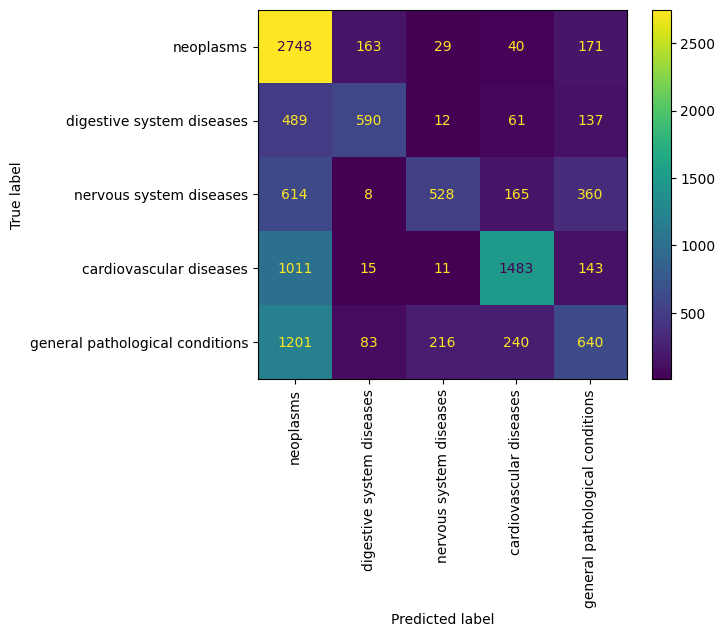

In [109]:
cm = confusion_matrix(train_df.label, bert_topic_train_preds, labels=list(range(1,6)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=topics)
disp.plot(xticks_rotation=90);

I believe this is due to the first category, a rather large one, being labeled as 'neoplasms' (the '0' assignment in bert_topic_cats).  There should probably a finer granularity set of categories.

In [110]:
bert_topic_cats

[0, 3, 0, 1, 3, 4, 0, 2, 2, 4, 4, 4, 2, 0, 4, 4, 4, 4, 3, 2]

But if I look at the second cluster, it has a label of '3', corresponding to cardiovascular diseases.  That makes sense given the representative document 'Angiographic progression to total coronary occlusion...'.

The third cluster has a label of '0' ('neoplasms' ).  Again, this makes sense given the representative document 'Follicular thyroid cancer...'

The fourth cluster has a label of '1' ('digestive system diseases' ).  Again, this makes sense given the representative document 'Primary carcinoma of the gallbladder...'

In other words, the representative documents are *extremely* helpful in identifying topics.  Also, they illustrate that perhaps having 1 label per document is inadequate, and thus explain why the original classification task was tough in the first place.  To me, a document like 'Primary carcinoma of the gallbladder...' has 2 topics - 'digestive system' and 'neoplasm'.

This illustrates perhaps one of the biggest disadvantages of BERTopic - a document can be assigned only 1 topic.  LDA can assign multiple ones.  Matrix factorization like NMF and LSA can as well.

# Results and Discussion

The coherence and accuracy scores for each of the four topic models is presented below.

In [111]:
accs = [lsa_acc, nmf_acc, lda_acc, bert_topic_acc]
coherencies = [lsa_coherence, nmf_coherence, lda_coherence, bertopic_coherence]
reddf = pd.DataFrame({'model': ['LSA', 'NMF', 'LDA', 'BERTopic'], 'accuracy': accs, 'coherency': coherencies})
reddf

,model,accuracy,coherency
0,LSA,0.350511,-5.053764
1,NMF,0.545707,-3.508208
2,LDA,0.537731,-3.436115
3,BERTopic,0.536745,-0.237193


There were 2 reasons I didn't include diversity as a metric:

1. The traditional method diversity of calculating diversity doesn't take into account semantic similarity
2. I have no out-of-the box-implementation of this for LDA and BERTopic.

Addressing these is beyond the scope of this project.

NMF, LDA and BERTopic all have similar accuracies when predicting the label on the training set.  Only LSA is substantially worse.  SVD introduces strange things for the application of topic modeling such as negative values.  The only reason I included LSA was because SVD was covered in class.  In practice, I wouldn't waste my time on it, and use a more modern method like Top2Vec [5] (which I ran out of time to get to.)

We had the benefit of being given the topic labels for the documents.  This is unusual.  If I had to pick the topic based on the most informative words for NMF and LDA, I would have a hard time.  Having representative documents, like BERTopic does, is extremely helpful.  There may be ways of having representative documents for the matrix factorization methods, but I strongly suspect that since they are treating documents like bags-of-words, those methods won't perform as well since context is not considered.

One of the big downsides of using BERTopic (or any other LM-based method, for example TopVec) is that you need substantial computing power - preferably with a GPU.  You might not though if your documents are short (less than 500 tokens.) Shorter documents are preferable with BERTopic since it only assings one topic, unlike the matrix factorization methods (LSA and NMF) and LDA.

LDA was also extremely slow, especially compared to LSA and NMF.  

LSA, NMF and LDA all require serious pre-processing.  I don't show it in this notebook but I did try various methods of cleaning the data to get these to work reasonably (ex. different sets of stop words.)  And I tried various numbers of topics to get one that worked reasonably well across most of the models (except LSA.) This hyperparameter tuning is time consuming especially without labels or decent metrics.  It's *very* nice to just feed documents to BERTopic and have it automatically pick the number of topics for you.

Since we don't have labels, it would be nice to have reliable, *automated* tools for evaluating topic clusters.  I did not spend enough time on this.  What I found available seemed inadequate.

One of the ways all models can likely improve is using tools specific to the biomedical domain - stopword lists, lemmatizers, and language models like ClinicalBERT or BioMedical BERT.  I do believe it's reasonable to start with tools that aren't domain specific to get baselines.

# Conclusion

Topic modeling is hard.  We attempted to extract topics from a corpus of medical abstracts.  These have already been labeled for another task, which allowed us to compare LSA, NMF, LDA and BERTopic.  NMF, LDA and BERTopic all performed reasonably well, having pros and cons each.  In the future, we could explore more modern methods that use LMs like Top2Vec and employ biomedical resources.

# References

1. Devlin, Jacob, et al. "Bert: Pre-training of deep bidirectional transformers for language understanding." arXiv preprint arXiv:1810.04805 (2018).
2. Grootendorst, Maarten. "BERTopic: Neural topic modeling with a class-based TF-IDF procedure." arXiv preprint arXiv:2203.05794 (2022).
3. Reimers, Nils, and Iryna Gurevych. "Sentence-bert: Sentence embeddings using siamese bert-networks." arXiv preprint arXiv:1908.10084 (2019).
4. Vaswani, Ashish, et al. "Attention is all you need." Advances in neural information processing systems 30 (2017).
5. Angelov, Dimo. "Top2vec: Distributed representations of topics." arXiv preprint arXiv:2008.09470 (2020).